In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
#import os
import pathlib
import typing

import numpy as np
import pandas as pd

import scipy.ndimage

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [4]:
data_dict = load_data('/research/rih-cs/datasets/elvo/v1/data')

In [5]:
labels_df = pd.read_csv('/research/rih-cs/datasets/elvo/v1/labels.csv',
                        index_col='patient_id')

In [6]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [7]:
data_dict = process_images(data_dict)

In [8]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    return labels

In [9]:
labels_df = process_labels(labels_df, data_dict)

/gpfs/main/home/aeweber/elvo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [10]:
def process_labels_data(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # Removes images with no label
    patient_id_null = labels[labels.isnull().any(axis=1)]
    index = list(patient_id_null.index) 
    for name in index:
        del data[name]
    labels = labels.dropna()
    return data, labels

In [11]:
data_dict, labels_df = process_labels_data(labels_df, data_dict)

# Getting Pictures (Before Cropping)

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id][:,:,110])
    fig.tight_layout()
    plt.plot()

In [14]:
def plot_mipped_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [15]:
# Change the input to .transpose to see different views of the data
mipped_all = {k:data_dict[k].transpose(0, 2, 1).max(axis=2) for i, k in enumerate(data_dict)}

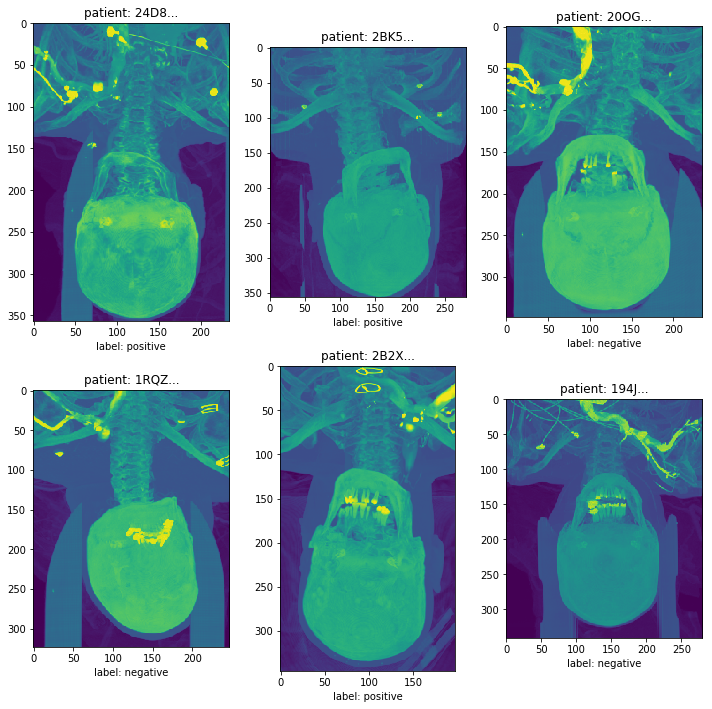

In [21]:
plot_mipped_images({k: arr for k, arr in mipped_all.items()}, labels_df, 3, 6, offset=2)

# More Preprocessing (Cropping)

In [12]:
def crop(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = max(output_shape[0], i - 30)
            break
    height_min = height_max - output_shape[0]
    
    cropped = image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]
    assert cropped.shape == output_shape
    return cropped

def normalize(image3d: np.ndarray) -> np.ndarray:
    min_bound = -200.0
    max_bound = 400.0
    image3d = (image3d - min_bound)/(max_bound - min_bound)
    image3d[image3d > 1] = 1.
    image3d[image3d < 0] = 0.
    return image3d


In [13]:
def process_3d(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
            arr = crop(arr, (190, 200, 200))
            arr = normalize(arr)  #Don't include for images
            processed[id_] = [arr] # extra brackets added to make it into pandas
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
    return processed

In [14]:
processed_3d = process_3d(data_dict)

image for patient 2B2XLE17Y0C5WJ3T too small, has shape (346, 198, 198)
image for patient 2STQ3IYP5SV7XIPG too small, has shape (316, 198, 198)
image for patient 1RL0HZOC3A7JWJL1 too small, has shape (162, 250, 250)
image for patient NQXVKFP54XTD3GVF too small, has shape (269, 199, 199)
image for patient WB6U44ZD7QACX6JM too small, has shape (185, 275, 275)
image for patient TGXRI16H1J321FI0 too small, has shape (329, 195, 195)
image for patient H0MSX6TSVLWG2LW too small, has shape (322, 192, 192)
image for patient QPDX2K3DS7IS5QNM too small, has shape (351, 191, 191)
image for patient KK0ZHCZR9V87OESW too small, has shape (297, 197, 197)
image for patient FMYU2WQIQCFQBIFS too small, has shape (164, 250, 250)
image for patient X4GQ56MK0E0YNL0E too small, has shape (232, 180, 180)
image for patient RL7MPCDASC5FXBRJ too small, has shape (160, 250, 250)
image for patient 2ZF1T5U8LU7SMI4Y too small, has shape (342, 198, 198)
image for patient 86HEMQMXXRRXM9S0 too small, has shape (183, 250

In [15]:
processed_df = labels_df.loc[processed_3d.keys()]

# Getting Images (after Cropping)
To get images we did not normalize in the above, to get greater constrast in images

In [38]:
processed_3d_trans = {k:processed_3d[k][0].transpose(0, 2,1) for i, k in enumerate(processed_3d)}

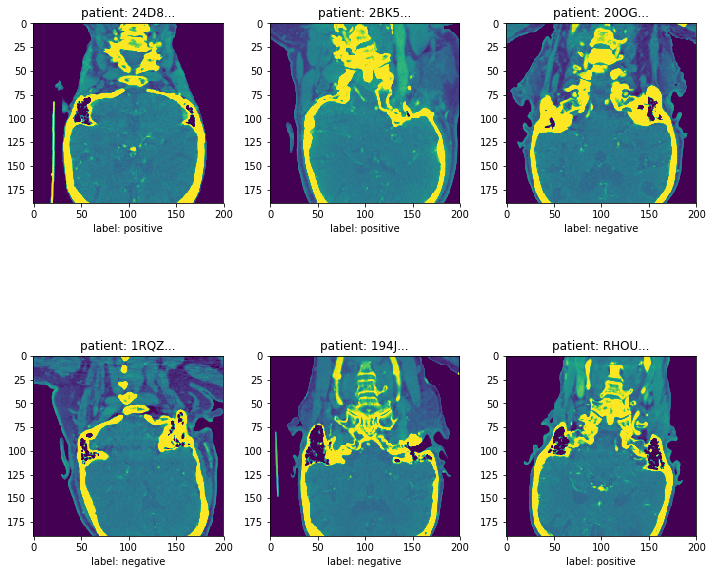

In [41]:
plot_images({k: arr for k, arr in processed_3d_trans.items()}, labels_df, 3, 6, offset=2)

# Model

In [16]:
class Model:

    def __init__(self, image, label, keep_rate, is_training):
        """
        A Model class contains a computational graph that classifies images
        to predictions. Each of its methods builds part of the graph
        on Model initialization. Do not modify the constructor, as doing so
        would break the autograder. You may, however, add class variables
        to use in your graph-building. e.g. learning rate, 

        image: the input image to the computational graph as a tensor
        label: the correct label of an image as a tensor
        prediction: the output prediction of the computational graph,
                    produced by self.forward_pass()
        optimize: the model's optimizing tensor produced by self.optimizer()
        loss: the model's loss produced by computing self.loss_function()
        accuracy: the model's prediction accuracy
        """
        self.image = image
        #turn labels into one hots
        self.label = tf.one_hot(tf.cast(label, dtype = tf.int32), 2)
        self.keep_rate = keep_rate
        self.is_training = is_training
        

        self.prediction = self.forward_pass()
        self.loss = self.loss_function()
        self.optimize = self.optimizer()
        self.accuracy = self.accuracy_function()
        self.recall, self.recall_update = self.recall()
        self.precision, self.precision_update = self.precision()

    def forward_pass(self):
        """
        Predicts a label given an image using convolution layers

        :return: the prediction as a tensor
        """
        #image_size 190x200x200
        img = tf.reshape(self.image, [-1, 190, 200, 200, 1])
        #image_size reshape => 190x200x200
        conv1 = tf.layers.conv3d(inputs =img, filters = 8, kernel_size = [10, 10, 10], strides = 5, padding = "SAME", activation = tf.nn.relu)
        #image_size conv1 => 38x40x40
        #bn1 = tf.layers.batch_normalization(inputs=conv1, training=self.is_training)
        pool1 = tf.layers.max_pooling3d(inputs = conv1, pool_size = [2, 2, 2], strides = 2)
        #image_size pool1 => 19x20x20
        
        conv2 = tf.layers.conv3d(inputs = pool1, filters = 16, kernel_size = [3, 3, 3], padding = "SAME", activation = tf.nn.relu)
        #image_size conv2 => 19x20x20
        #bn2 = tf.layers.batch_normalization(inputs=conv2, training=self.is_training)
        pool2 = tf.layers.max_pooling3d(inputs = conv2, pool_size = [2, 2, 2], strides = 2)
        #image_szie pool2 => 9x10x10
        
        conv3 = conv2 = tf.layers.conv3d(inputs = pool2, filters = 32, kernel_size = [3, 3, 3], padding = "SAME", activation = tf.nn.relu)
        #image_size conv3 => 9x10x10
        pool3 = tf.layers.max_pooling3d(inputs = conv3, pool_size = [2, 2, 2], strides = 2)
        #image_size pool3 => 4x5x5
        
        cnn3d_bn = tf.layers.batch_normalization(inputs=pool3, training=self.is_training)
        
        #fully connected layers
        flattening = tf.reshape(cnn3d_bn, [-1, 4*5*5*32])
        dense = tf.layers.dense(inputs = flattening, units = 1500, activation = tf.nn.relu)
        # (1-keep_rate) is the probability that the node will be kept
        dropout = tf.layers.dropout(inputs=dense, rate=self.keep_rate, training=True)
        
        logits = tf.layers.dense(inputs=dropout, units=2)
        
        return logits
        
    def loss_function(self):
        """
        Calculates the model cross-entropy loss

        :return: the loss of the model as a tensor
        """
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.prediction, labels=self.label))
        return loss
        

    def optimizer(self):
        """
        Optimizes the model loss using an Adam Optimizer

        :return: the optimizer as a tensor
        """
        learning_rate = 1e-4
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        return train_op
    
    def recall(self):
        recall, recall_update = tf.metrics.recall(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        return recall, recall_update
    
    def precision(self):
        
        precision, precision_update = tf.metrics.precision(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        #false_pos, false_pos_update = tf.metrics.false_positives(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        #false_neg = tf.metrics.false_negatives(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        #true_pos = tf.metrics.true_positives(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        
        return precision, precision_update
        

    def accuracy_function(self):
        """
        Calculates the model's prediction accuracy by comparing
        predictions to correct labels – no need to modify this

        :return: the accuracy of the model as a tensor
        """
        correct_prediction = tf.equal(tf.argmax(self.prediction, 1),
                                      tf.argmax(self.label, 1))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame.from_dict(processed_3d, orient = 'index'), processed_df, test_size=0.20)

In [18]:
X_train = X_train.values.tolist() # np.shape(X_train) = (947,1,120,200,200)
y_train = y_train.values.tolist() # np.shape(y_train) = (947, 1)

X_test = X_test.values.tolist() # np.shape(X_test) = (237,1,120,200,200)
y_test = y_test.values.tolist() # np.shape(y_test) = (237,1)

In [19]:
X_train = np.squeeze(X_train) # np.shape(X_train_list) = (947,120,200,200), np.squeeze gets rid of dimension 1
y_train = np.squeeze(y_train) # np.shape(y_train_list) = (947,)

X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)

In [20]:
del processed_3d
del processed_df
del data_dict
del labels_df

# # Data Augmentation

In [21]:
def rotate180(data: np.ndarray,
         axes1, axes2) -> np.ndarray:
    """Rotates an image by 180 degrees with respect to the given axes
    """
    rotation = []
    for image in data:
        rotation.append(scipy.ndimage.interpolation.rotate(image, 180, axes = (axes1,axes2)))
    return rotation
def translate(data: np.ndarray,
         t1, t2, t3) -> np.ndarray:
    """Translates/shifts an image by [t1, t2, t3] units  
    TO GET "GOOD" TRANSLATE THAT DON'T CHOP THE BRAIN MUCH DO [0, NUMBER, 0]
    """
    translate = []
    for image in data:
        translate.append(scipy.ndimage.shift(image, [t1, t2, t3], mode = 'nearest')) 
    """We can change the mode if we want to be constant to whatever number seems more common,
    this mode fills in like this: aaa/abc/ccc""" 
    return np.array(translate)

In [22]:
#rotate_data = rotate180(X_train, 0, 1)
#rotate_label = y_train
redo = True
while redo: 
    s1 = np.arange(X_train.shape[0])
    X_train = X_train[s1]
    y_train = y_train[s1]
    if 0.4 <= np.count_nonzero(y_train)/len(y_train) <= 0.5:
        redo = False
translate1_data = translate(X_train[0:100], 0, 15, 0)
translate2_data = translate(X_train[100:200], 0, -15, 0)
translate3_data = translate(X_train[200:300], 15, 0, 0)
translate4_data = translate(X_train[300:400], -15, 0, 0)
translate5_data = translate(X_train[400:500], -15, 15, 0)

In [23]:
X_train = np.concatenate((X_train, translate1_data, translate2_data, translate3_data, translate4_data, translate5_data))
y_train = np.concatenate((y_train, y_train[0:500]))

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

In [24]:
batchSz = 5
    
#Image and answer placeholders
img = tf.placeholder(tf.float32, [None, 190, 200, 200]) #We have to reshape this in the model...
ans = tf.placeholder(tf.float32, [None])
keep_rate = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

model = Model(img, ans, keep_rate, is_training)

#start tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [25]:
#Training loop
train_range = len(X_train)//batchSz
for j in range(10):
    for i in range(train_range):
        imgs = X_train[i*batchSz: (i+1)*batchSz]
        anss = y_train[i*batchSz: (i+1)*batchSz]
        sess.run(model.optimize, feed_dict = {img: imgs, ans: anss, keep_rate: 0.5, is_training: False})
    print ("----EPOCH %r -------" %j)

----EPOCH 0 -------
----EPOCH 1 -------
----EPOCH 2 -------
----EPOCH 3 -------
----EPOCH 4 -------
----EPOCH 5 -------
----EPOCH 6 -------
----EPOCH 7 -------
----EPOCH 8 -------
----EPOCH 9 -------


In [26]:
# Test Accuracy
sumAcc = 0
test_range = len(X_test)//batchSz
for i in range(test_range):
    imgs = X_test[i*batchSz: (i+1)*batchSz]
    anss = y_test[i*batchSz: (i+1)*batchSz]
    sumAcc1, _, _ = sess.run([model.accuracy, model.recall_update, model.precision_update], feed_dict = {img: imgs, ans: anss, keep_rate: 0, is_training: False})
    sumAcc += sumAcc1
precision = sess.run(model.precision)
recall = sess.run(model.recall)
print ("Test Accuracy: %r" % (sumAcc/test_range)) 
print ("Test Precision: %r" % precision) #precision = true_pos/(true_pos + false_pos)
print ("Test Recall: %r" %recall) #recall = true_pos/(true_pos + false_neg)

Test Accuracy: 0.6255319261170448
Test Precision: 0.6183206
Test Recall: 0.6806723


In [27]:
# Train Accuracy
sess.run(tf.local_variables_initializer())
sumAcc = 0
for i in range(train_range):
    imgs = X_train[i*batchSz: (i+1)*batchSz]
    anss = y_train[i*batchSz: (i+1)*batchSz]
    #sumAcc1 = sess.run(model.accuracy, feed_dict = {img: imgs, ans: anss, keep_rate: 0, is_training: True})
    sumAcc1, recall, _, _ = sess.run([model.accuracy, model.recall, model.recall_update, model.precision_update], feed_dict = {img: imgs, ans: anss, keep_rate: 0, is_training: False})
    sumAcc += sumAcc1
precision = sess.run(model.precision)
recall = sess.run(model.recall)
print ("Train Accuracy: %r" % (sumAcc/train_range))  
print ("Train Precision: %r" %precision)
print ("Train Recall: %r" %recall) 

Train Accuracy: 0.8993055612469713
Train Precision: 0.82945734
Train Recall: 0.98015267
